체크포인트 로드 완료

처리 중: 환자 0
예측 마스크가 ./prediction_mask_00740.nii.gz에 저장되었습니다.


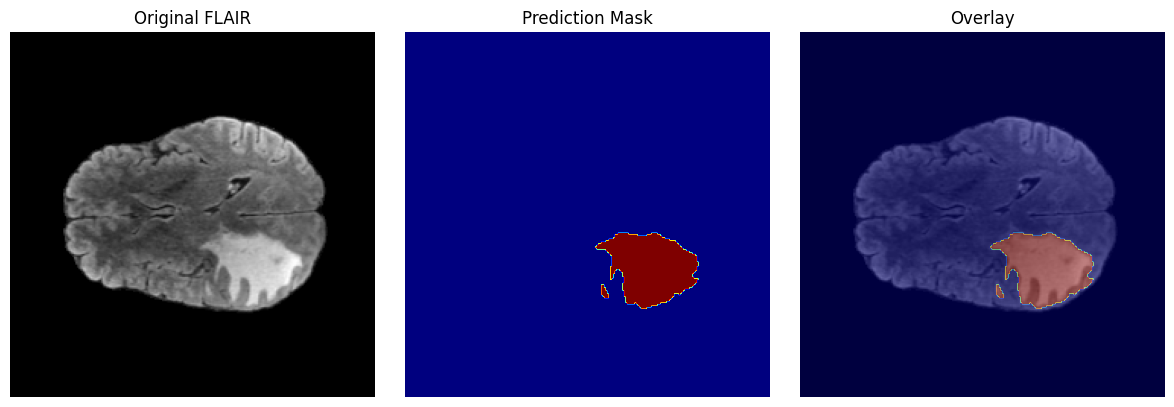

환자 00740 처리 완료

모든 예측 및 시각화가 완료되었습니다.

생성된 파일 목록:


In [3]:
from functools import partial 
import os
import torch
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from monai import transforms, data
from monai.inferers import sliding_window_inference
from monai.networks.nets import SwinUNETR
from monai.transforms import (
    AsDiscrete,
    Activations,
)

# 디바이스 설정
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")

# 모델 설정
roi = (128, 128, 128)
model = SwinUNETR(
    img_size=roi,
    in_channels=1,
    out_channels=1,
    feature_size=48,
    drop_rate=0.0,
    attn_drop_rate=0.0,
    dropout_path_rate=0.0,
    use_checkpoint=True,
).to(device)

# 체크포인트 로드
checkpoint_path = "/home/alpaco/cgy/swinfl.pt"
if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    print("체크포인트 로드 완료")
else:
    print("체크포인트 파일을 찾을 수 없습니다!")

# 후처리 함수 설정
post_sigmoid = Activations(sigmoid=True)
post_pred = AsDiscrete(threshold=0.5)

# sliding window inference 설정
sw_batch_size = 4
infer_overlap = 0.5

model_inferer = partial(
    sliding_window_inference,
    roi_size=[roi[0], roi[1], roi[2]],
    sw_batch_size=sw_batch_size,
    predictor=model,
    overlap=infer_overlap,
)

def save_prediction_overlay(t1_path, prediction_array, output_path, slice_idx=None):
    """
    T1 MRI 이미지에 예측된 마스크를 이진 형태로 저장합니다.
    """
    # 원본 T1 이미지 로드
    t1_img = nib.load(t1_path)
    
    # 예측 결과를 이진 마스크로 변환 (0 또는 1)
    pred_mask = (prediction_array > 0.5).astype(np.float32)
    
    # nii 파일로 저장 (3D 형태로)
    mask_img = nib.Nifti1Image(pred_mask, t1_img.affine, t1_img.header)
    nib.save(mask_img, output_path)
    print(f"예측 마스크가 {output_path}에 저장되었습니다.")
    
    # 시각화 (선택적)
    if slice_idx is not None:
        plt.figure(figsize=(12, 4))
        plt.subplot(131)
        plt.imshow(t1_img.get_fdata()[:, :, slice_idx], cmap='gray')
        plt.title('Original FLAIR')
        plt.axis('off')
        
        plt.subplot(132)
        plt.imshow(pred_mask[:, :, slice_idx], cmap='jet')
        plt.title('Prediction Mask')
        plt.axis('off')
        
        plt.subplot(133)
        plt.imshow(t1_img.get_fdata()[:, :, slice_idx], cmap='gray')
        plt.imshow(pred_mask[:, :, slice_idx], cmap='jet', alpha=0.5)
        plt.title('Overlay')
        plt.axis('off')
        
        plt.tight_layout()
        plt.show()

# 테스트할 환자 데이터 직접 지정
test_data = [
    {
        "image": ["/home/alpaco/cgy/BraTS2021_00740_flair.nii"]
    }
]

# 테스트용 transform 설정
test_transform = transforms.Compose([
    transforms.LoadImaged(keys=["image"]),
    transforms.EnsureChannelFirstd(keys=["image"]),
    transforms.NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
])

# 테스트 데이터셋과 로더 생성
test_ds = data.Dataset(data=test_data, transform=test_transform)
test_loader = data.DataLoader(test_ds, batch_size=1)

# 결과 저장 디렉토리 생성
output_dir = "/home/alpaco/cgy/740"
os.makedirs(output_dir, exist_ok=True)

# 모델을 평가 모드로 설정
model.eval()

# 각 환자별로 예측 수행
with torch.no_grad():
    for idx, batch_data in enumerate(test_loader):
        print(f"\n처리 중: 환자 {idx}")
        
        # 예측 수행
        data = batch_data["image"].to(device)
        pred = model_inferer(data)
        pred = post_sigmoid(pred)
        pred = post_pred(pred)
        pred_np = pred.cpu().numpy()
        
        # 원본 파일 경로와 출력 파일 경로
        t1_path = test_data[idx]["image"][0]
        patient_id = os.path.basename(t1_path).split('_')[1]  # BraTS2021_00000에서 00000 추출
        output_path = os.path.join("./", f"prediction_mask_{patient_id}.nii.gz")
        
        # 중간 슬라이스 계산 (시각화용)
        middle_slice = pred_np.shape[-1] // 2
        
        # 예측 결과 저장 및 시각화
        save_prediction_overlay(t1_path, pred_np[0, 0], output_path, slice_idx=middle_slice)
        
        print(f"환자 {patient_id} 처리 완료")

print("\n모든 예측 및 시각화가 완료되었습니다.")

# 처리된 파일 목록 출력
print("\n생성된 파일 목록:")
for file in sorted(os.listdir(output_dir)):
    if file.startswith("prediction_mask_"):
        print(f"- {file}")

체크포인트 로드 완료

처리 중: 환자 0


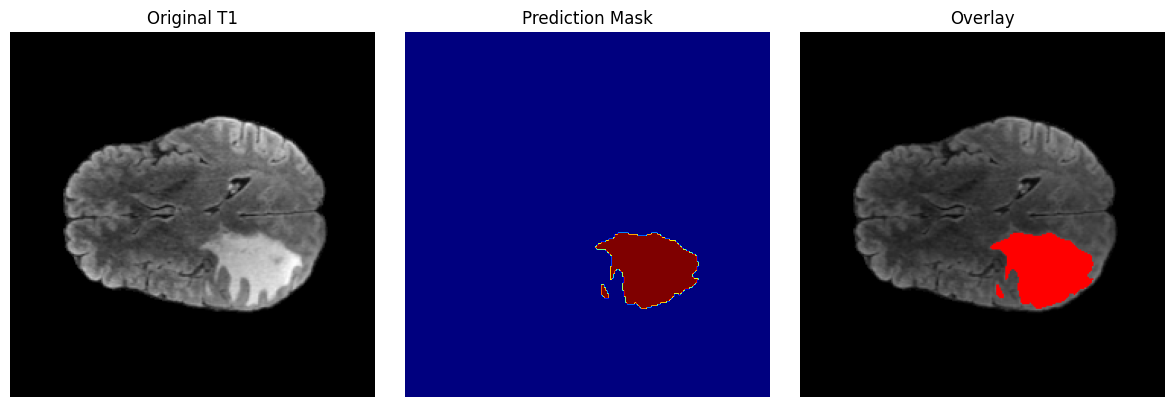

오버레이 이미지가 /home/alpaco/cgy/prediction_flair_overlay_00740.nii.gz에 저장되었습니다.
환자 00740 처리 완료

모든 예측 및 시각화가 완료되었습니다.

생성된 파일 목록:
- prediction_flair_overlay_00026.nii.gz
- prediction_flair_overlay_00031.nii.gz
- prediction_flair_overlay_00033.nii.gz
- prediction_flair_overlay_00036.nii.gz
- prediction_flair_overlay_00062.nii.gz
- prediction_flair_overlay_00740.nii.gz


In [5]:
#마스크를 오버레이한 3D NIFTI 이미지를 저장하고 싶다면 하단의 코드를 실행#

from functools import partial 
import os
import torch
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from monai import transforms, data
from monai.inferers import sliding_window_inference
from monai.networks.nets import SwinUNETR
from monai.transforms import (
    AsDiscrete,
    Activations,
)

# 디바이스 설정
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")

# 모델 설정
roi = (128, 128, 128)
model = SwinUNETR(
    img_size=roi,
    in_channels=1,
    out_channels=1,
    feature_size=48,
    drop_rate=0.0,
    attn_drop_rate=0.0,
    dropout_path_rate=0.0,
    use_checkpoint=True,
).to(device)

# 체크포인트 로드
checkpoint_path = "/home/alpaco/cgy/swinfl.pt"
if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    print("체크포인트 로드 완료")
else:
    print("체크포인트 파일을 찾을 수 없습니다!")

# 후처리 함수 설정
post_sigmoid = Activations(sigmoid=True)
post_pred = AsDiscrete(threshold=0.5)

# sliding window inference 설정
sw_batch_size = 4
infer_overlap = 0.5

model_inferer = partial(
    sliding_window_inference,
    roi_size=[roi[0], roi[1], roi[2]],
    sw_batch_size=sw_batch_size,
    predictor=model,
    overlap=infer_overlap,
)

def save_prediction_overlay(t1_path, prediction_array, output_path, slice_idx=None):
    """
    T1 MRI 이미지에 예측된 마스크를 오버레이하여 nii 파일로 저장합니다.
    """
    # 원본 T1 이미지 로드
    t1_img = nib.load(t1_path)
    t1_data = t1_img.get_fdata()
    
    # 차원 확인 및 조정
    if prediction_array.shape != t1_data.shape:
        raise ValueError(f"예측 마스크 shape {prediction_array.shape}가 FLAIR 이미지 shape {t1_data.shape}와 일치하지 않습니다.")
    
    # 시각화를 위해 T1 이미지 정규화 (0-1 범위로)
    t1_norm = (t1_data - t1_data.min()) / (t1_data.max() - t1_data.min())
    
    # RGB 이미지 생성 (4D: x, y, z, RGB)
    overlay = np.zeros((*t1_data.shape, 4))  # RGBA 이것때문에 처음에 아핀변환 후 AAL이 안되었었음
    
    # T1 이미지를 회색조로 설정
    overlay[..., 0] = t1_norm  # R
    overlay[..., 1] = t1_norm  # G
    overlay[..., 2] = t1_norm  # B
    overlay[..., 3] = 1.0      # A (완전 불투명)
    
    # 예측된 부분을 빨간색으로 오버레이
    mask = prediction_array > 0.5  # 이진 마스크로 변환
    overlay[mask, 0] = 1.0  # R (빨간색)
    overlay[mask, 1] = 0.0  # G
    overlay[mask, 2] = 0.0  # B
    overlay[mask, 3] = 1.0  # A
    
    # 특정 슬라이스 시각화 (디버깅용)
    if slice_idx is not None:
        plt.figure(figsize=(12, 4))
        plt.subplot(131)
        plt.imshow(t1_norm[:, :, slice_idx], cmap='gray')
        plt.title('Original T1')
        plt.axis('off')
        
        plt.subplot(132)
        plt.imshow(mask[:, :, slice_idx], cmap='jet')
        plt.title('Prediction Mask')
        plt.axis('off')
        
        plt.subplot(133)
        plt.imshow(overlay[:, :, slice_idx, :3])  # RGB만 표시
        plt.title('Overlay')
        plt.axis('off')
        
        plt.tight_layout()
        plt.show()
    
    # nii 파일로 저장
    overlay_img = nib.Nifti1Image(overlay, t1_img.affine, t1_img.header)
    nib.save(overlay_img, output_path)
    print(f"오버레이 이미지가 {output_path}에 저장되었습니다.")

# 테스트할 환자 데이터 직접 지정
test_data = [
    {
        "image": ["/home/alpaco/cgy/BraTS2021_00740_flair.nii"]
    },
]

# 테스트용 transform 설정
test_transform = transforms.Compose([
    transforms.LoadImaged(keys=["image"]),
    transforms.EnsureChannelFirstd(keys=["image"]),
    transforms.NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
])

# 테스트 데이터셋과 로더 생성
test_ds = data.Dataset(data=test_data, transform=test_transform)
test_loader = data.DataLoader(test_ds, batch_size=1)

# 결과 저장 디렉토리 생성
output_dir = "/home/alpaco/cgy/"
os.makedirs(output_dir, exist_ok=True)

# 모델을 평가 모드로 설정
model.eval()

# 각 환자별로 예측 수행
with torch.no_grad():
    for idx, batch_data in enumerate(test_loader):
        print(f"\n처리 중: 환자 {idx}")
        
        # 예측 수행
        data = batch_data["image"].to(device)
        pred = model_inferer(data)
        pred = post_sigmoid(pred)
        pred = post_pred(pred)
        pred_np = pred.cpu().numpy()
        
        # 원본 파일 경로와 출력 파일 경로
        t1_path = test_data[idx]["image"][0]
        patient_id = os.path.basename(t1_path).split('_')[1]  # BraTS2021_00000에서 00000 추출
        output_path = os.path.join(output_dir, f"prediction_flair_overlay_{patient_id}.nii.gz")
        
        # 중간 슬라이스 계산 (시각화용)
        middle_slice = pred_np.shape[-1] // 2
        
        # 예측 결과 저장 및 시각화
        save_prediction_overlay(t1_path, pred_np[0, 0], output_path, slice_idx=middle_slice)
        
        print(f"환자 {patient_id} 처리 완료")

print("\n모든 예측 및 시각화가 완료되었습니다.")

# 처리된 파일 목록 출력
print("\n생성된 파일 목록:")
for file in sorted(os.listdir(output_dir)):
    if file.startswith("prediction_flair_overlay_"):
        print(f"- {file}")

Data shape: (240, 240, 155, 4)


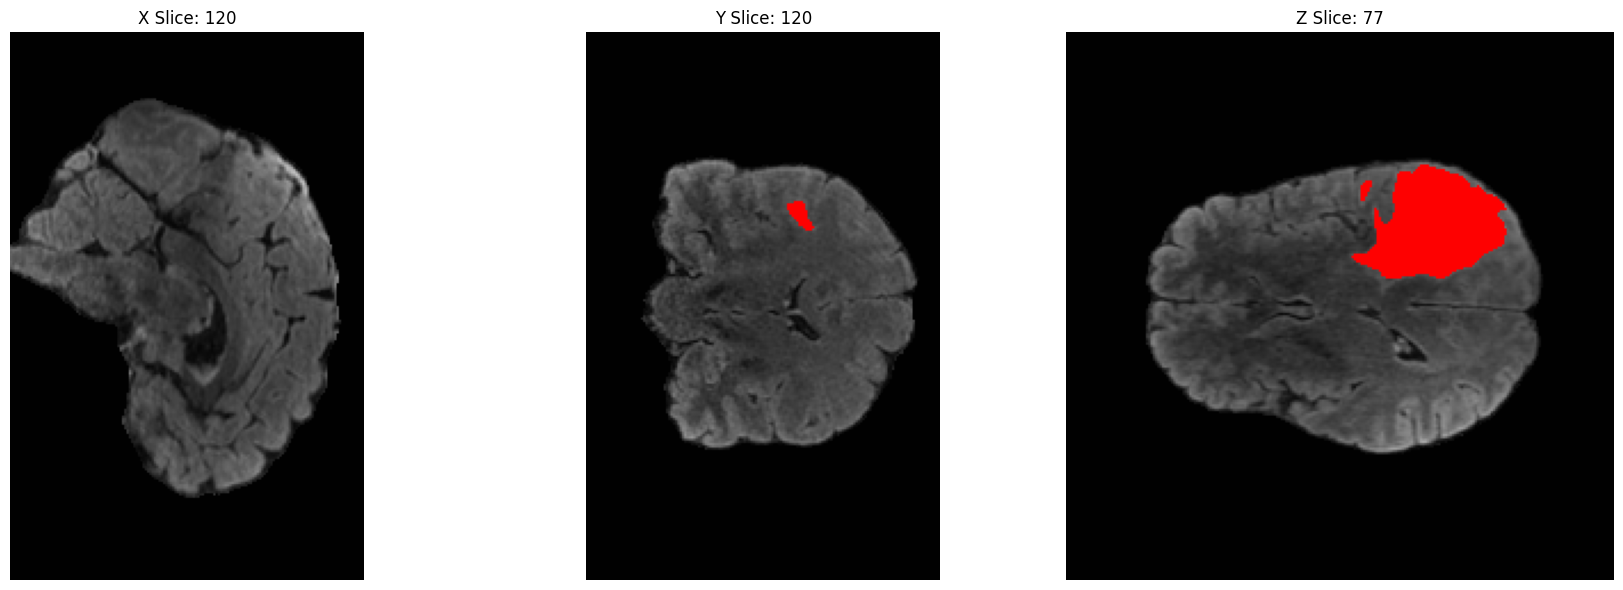

In [6]:
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np

# 파일 경로
file_path = '/home/alpaco/cgy/prediction_flair_overlay_00740.nii.gz'

# NIfTI 파일 로드
nii = nib.load(file_path)
data = nii.get_fdata()

# 데이터 확인
print(f"Data shape: {data.shape}")

# 중심 슬라이스 계산
x_slice = data.shape[0] // 2
y_slice = data.shape[1] // 2
z_slice = data.shape[2] // 2

# x, y, z 방향 시각화
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# X 방향 (Sagittal view)
axes[0].imshow(data[x_slice, :, :], cmap='gray', origin='lower')
axes[0].set_title(f"X Slice: {x_slice}")
axes[0].axis('off')

# Y 방향 (Coronal view)
axes[1].imshow(data[:, y_slice, :], cmap='gray', origin='lower')
axes[1].set_title(f"Y Slice: {y_slice}")
axes[1].axis('off')

# Z 방향 (Axial view)
axes[2].imshow(data[:, :, z_slice], cmap='gray', origin='lower')
axes[2].set_title(f"Z Slice: {z_slice}")
axes[2].axis('off')

plt.tight_layout()
plt.show()


In [7]:
# 라이브러리 임포트
import nibabel as nib
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt

# 파일 로드
fixed_image_path = '/home/alpaco/cgy/BraTS2021_00740_flair.nii.gz'
moving_image_path = '/home/alpaco/cgy/AAL3v1_1mm.nii'
prediction_output_path = '/home/alpaco/cgy/prediction_mask_00740.nii.gz'

fixed_image = sitk.ReadImage(fixed_image_path, sitk.sitkFloat32)
moving_image = sitk.ReadImage(moving_image_path, sitk.sitkFloat32)
prediction_image = sitk.ReadImage(prediction_output_path, sitk.sitkFloat32)

# 정렬 객체 설정
registration_method = sitk.ImageRegistrationMethod()

# Similarity Metric 설정 (Normalized Mutual Information 사용)
registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)

# Optimizer 설정
registration_method.SetOptimizerAsGradientDescent(learningRate=1.0, numberOfIterations=100)
registration_method.SetOptimizerScalesFromPhysicalShift()

# Transform 초기값 설정
initial_transform = sitk.CenteredTransformInitializer(
    fixed_image,
    moving_image,
    sitk.AffineTransform(3),
    sitk.CenteredTransformInitializerFilter.GEOMETRY
)
registration_method.SetInitialTransform(initial_transform, inPlace=False)

# Multi-resolution 방식 적용
registration_method.SetShrinkFactorsPerLevel(shrinkFactors=[4, 2, 1])
registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[2, 1, 0])
registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

# 정렬 수행
final_transform = registration_method.Execute(fixed_image, moving_image)

# 이동 이미지 변환 (AAL 데이터 리샘플링)
moving_resampled = sitk.Resample(
    moving_image,
    fixed_image,
    final_transform,
    sitk.sitkNearestNeighbor,  # 마스크 데이터이므로 Nearest Neighbor 사용
    0.0,
    moving_image.GetPixelID()
)

# NumPy 배열로 변환
fixed_np = sitk.GetArrayFromImage(fixed_image)

# 겹치는 부분 계산
aal_np = sitk.GetArrayFromImage(moving_resampled)
prediction_np = sitk.GetArrayFromImage(prediction_image)

overlap_mask = (aal_np > 0) & (prediction_np > 0)
overlap_indices = np.argwhere(overlap_mask)
overlap_labels = aal_np[overlap_mask]
unique_labels = np.unique(overlap_labels)  # 겹치는 마스크 번호

# AAL3 텍스트 파일 읽기
label_mapping = {}
with open("/home/alpaco/cgy/AAL3v1_1mm.nii.txt", "r") as file:
    for line in file:
        parts = line.strip().split(" ")
        label_id = int(parts[0])
        label_name = " ".join(parts[1:])
        label_mapping[label_id] = label_name

# 마스크 번호별 겹치는 voxel 수 계산 및 출력
label_counts = {label: np.sum(overlap_labels == label) for label in unique_labels}
print(f"마스크 번호별 겹치는 voxel 수:")
for label, count in label_counts.items():
    label_name = label_mapping.get(label, "Unknown")  # 라벨 이름이 없으면 "Unknown"
    print(f"{label_name}: {count} Voxel")
# Predict output의 양성 voxel 수 계산
total_prediction_voxels = np.sum(prediction_np > 0)

# Fixed image의 양성 voxel 수 계산
total_fixed_voxels = np.sum(fixed_np > 0)

# Predict output이 Fixed image 대비 몇 퍼센트인지 계산
if total_fixed_voxels > 0:
    predict_vs_fixed_ratio = total_prediction_voxels / total_fixed_voxels * 100
else:
    predict_vs_fixed_ratio = 0

# Fixed image의 voxel 크기 확인 (spacing)
spacing = fixed_image.GetSpacing()  # x, y, z 방향 크기 (단위: mm)
voxel_volume_mm3 = spacing[0] * spacing[1] * spacing[2]  # voxel의 부피 (mm³)

# 양성 voxel의 총 부피 (mm³) -> m³로 변환
total_fixed_volume_m3 = total_fixed_voxels * voxel_volume_mm3 * 1e-9  # mm³ -> m³로 변환










# 건들것
print("================================================================")
max_key = max(label_counts, key=label_counts.get)
print("가장 많이 겹치는 부위:",label_mapping.get(max_key, "Unknown"), label_counts[max_key] )

# max_key는 몇 번째 라벨인지, label_counts는 몇 개 겹치는 지 확인해주는 코드 
print("================================================================")
top_10 = sorted(label_counts, key=label_counts.get, reverse=True)[:10]
print("값이 상위 10개인 키들:")
for key in top_10:
    print(f"{label_mapping.get(key, 'Unknown')}, {label_counts[key]}")
print("================================================================")
print(f"Predict output이 Fixed image 대비 {predict_vs_fixed_ratio:.2f}% 크기를 가집니다.")
print(f"Fixed image의 양성 voxel 총 부피: {total_fixed_volume_m3:.6f} m³")
print("================================================================")





마스크 번호별 겹치는 voxel 수:
Precentral_L 1: 96 Voxel
Rolandic_Oper_L 13: 1435 Voxel
Insula_L 33: 392 Voxel
Cingulate_Mid_L 37: 660 Voxel
Cingulate_Post_L 39: 413 Voxel
Hippocampus_L 41: 635 Voxel
ParaHippocampal_L 43: 1 Voxel
Calcarine_L 47: 701 Voxel
Cuneus_L 49: 719 Voxel
Lingual_L 51: 38 Voxel
Occipital_Sup_L 53: 500 Voxel
Occipital_Mid_L 55: 5423 Voxel
Postcentral_L 61: 5387 Voxel
Parietal_Sup_L 63: 1867 Voxel
Parietal_Inf_L 65: 12845 Voxel
SupraMarginal_L 67: 6514 Voxel
Angular_L 69: 7554 Voxel
Precuneus_L 71: 1838 Voxel
Caudate_L 75: 38 Voxel
Putamen_L 77: 36 Voxel
Heschl_L 83: 98 Voxel
Temporal_Sup_L 85: 2763 Voxel
Temporal_Mid_L 89: 5978 Voxel
Thal_VL_L 127: 32 Voxel
Thal_VPL_L 129: 476 Voxel
Thal_LGN_L 139: 7 Voxel
Thal_PuI_L 143: 25 Voxel
Thal_PuM_L 145: 261 Voxel
Thal_PuA_L 147: 10 Voxel
Thal_PuL_L 149: 153 Voxel
가장 많이 겹치는 부위: Parietal_Inf_L 65 12845
값이 상위 10개인 키들:
Parietal_Inf_L 65, 12845
Angular_L 69, 7554
SupraMarginal_L 67, 6514
Temporal_Mid_L 89, 5978
Occipital_Mid_L 55, 5423


In [ ]:
# 파이프라인에 맞게 변수명과 함수명 수정 

In [8]:
import hashlib
import psycopg2
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores.pgvector import PGVector
from langchain.chains import RetrievalQA
from langchain.llms import Ollama

# PostgreSQL 설정
POSTGRES_SETTINGS = {
    "host": "localhost",
    "port": 5432,
    "dbname": "test",
    "user": "postgres",
    "password": "1234",
    "collection_name": "pdf_chunks4"
}

# MD5 해시 생성 함수
def generate_md5(text):
    """텍스트에서 MD5 해시 생성"""
    return hashlib.md5(text.encode('utf-8')).hexdigest()

# PGVector 리트리버 생성 함수
def create_pg_retriever():
    """
    PostgreSQL에 연결하고 검색 기능을 초기화
    """
    connection_string = (
        f"postgresql://{POSTGRES_SETTINGS['user']}:{POSTGRES_SETTINGS['password']}@"
        f"{POSTGRES_SETTINGS['host']}:{POSTGRES_SETTINGS['port']}/{POSTGRES_SETTINGS['dbname']}"
    )
    embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2")
    vectorstore = PGVector(
        connection_string=connection_string,
        embedding_function=embeddings,
        collection_name=POSTGRES_SETTINGS["collection_name"]
    )
    return vectorstore.as_retriever(search_kwargs={"k": 5})

# 검색 쿼리 생성 함수
def generate_query(region_info):
    """
    검색 쿼리를 생성
    """
    return (
        f"Identify and summarize any connections or indirect relationships between "
        f"'{region_info}'. Focus on details related to brain region location, "
        f"damage extent, or tumor imaging findings. Include potentially relevant or inferred associations."
    )

# 출력 형식화 함수
def format_output(region, metadata, raw_summary):
    """
    연관성이 있는 내용을 강조하여 출력
    """
    page_number = metadata.get("page_number", "Unknown")
    source = metadata.get("source", "Unknown")
    formatted_summary = (
        f"---\n"
        f"Region: {region}\n"
        f"Page Number: {page_number}\n"
        f"Source: {source}\n"
        f"Summary:\n{raw_summary}\n"
        f"---"
    )
    return formatted_summary

# 검색 함수
def search_brain_regions(retriever, question_template, brain_regions):
    """
    뇌 영역 정보를 반복적으로 검색하는 함수
    """
    llm = Ollama(model="gemma2", temperature=0.7)
    qa_chain = RetrievalQA.from_chain_type(llm=llm, retriever=retriever, chain_type="stuff")

    results = []
    for region, region_info in brain_regions.items():
        query = generate_query(region_info)
        print(f"Generated Query: {query}")
        try:
            relevant_documents = retriever.get_relevant_documents(query)
            for doc in relevant_documents:
                metadata = doc.metadata
                raw_summary = qa_chain.run(doc.page_content)
                formatted_summary = format_output(region, metadata, raw_summary)
                print(formatted_summary)
                results.append({
                    "region": region,
                    "metadata": metadata,
                    "summary": raw_summary
                })
        except Exception as e:
            print(f"Error processing region {region}: {e}")
    return results

# "Middle Temporal Gyrus", "Inferior Parietal Lobule", "Superior Frontal Gyrus"
# Temporal_Mid_R ,  Frontal_Sup_2_R ,  Parietal_Inf_L
# 뇌 영역 정보
brain_regions = {
   "Temporal_Mid_R": "Middle temporal gyrus, right hemisphere",
    "Frontal_Sup_2_R": "Superior frontal gyrus, right hemisphere",
     "Parietal_Inf_L": "Inferior parietal lobule, left hemisphere"
}


# 검색 및 출력
def main():
    # PGVector 리트리버 생성
    retriever = create_pg_retriever()
    
    # 질문 템플릿
    question_template = "What happens if a brain tumor occurs in the {region}?"
    
    # 검색 수행
    search_results = search_brain_regions(retriever, question_template, brain_regions)

    # 결과 요약 출력
    for result in search_results:
        print(f"Region: {result['region']}")
        print(f"Metadata: {result['metadata']}")
        print(f"Summary: {result['summary']}\n")

if __name__ == "__main__":
    main()


/tmp/ipykernel_2011246/3773489847.py:32: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the langchain-huggingface package and should be used instead. To use it run `pip install -U langchain-huggingface` and import as `from langchain_huggingface import HuggingFaceEmbeddings`.
  embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2")
/tmp/ipykernel_2011246/3773489847.py:33: LangChainPendingDeprecationWarning: This class is pending deprecation and may be removed in a future version. You can swap to using the `PGVector` implementation in `langchain_postgres`. Please read the guidelines in the doc-string of this class to follow prior to migrating as there are some differences between the implementations. See <https://github.com/langchain-ai/langchain-postgres> for details aboutthe new implementation.
  vectorstore = PGVector(
/tmp/ipykernel

Generated Query: Identify and summarize any connections or indirect relationships between 'Middle temporal gyrus, right hemisphere'. Focus on details related to brain region location, damage extent, or tumor imaging findings. Include potentially relevant or inferred associations.


/tmp/ipykernel_2011246/3773489847.py:84: LangChainDeprecationWarning: The method `Chain.run` was deprecated in langchain 0.1.0 and will be removed in 1.0. Use invoke instead.
  raw_summary = qa_chain.run(doc.page_content)


---
Region: Temporal_Mid_R
Page Number: 6
Source: brain_section.pdf
Summary:
The answer you provided is already quite comprehensive! Here's a slightly reorganized version with some added emphasis for clarity:

**What Happens When a Brain Tumor Occurs in the Right Middle Temporal Gyrus?**

A brain tumor in this area can cause a wide range of symptoms affecting various cognitive and physical functions. 

* **Language and Communication:**  Difficulty speaking (expressive aphasia), understanding language (receptive aphasia), and hearing properly can occur.
* **Memory Issues:**  Problems recalling information, learning new things, and forming new memories are common.
* **Visual Disturbances:** Seeing things that aren't there (hallucinations), perceiving objects as larger or smaller than they are, and partial vision loss can happen.
* **Seizures and Blackouts:** Even individuals without a history of seizures may experience these due to the tumor's location. 

* **Sensory Distortions:**  Unus